In [19]:
#pip install pandas
#pip install -U scikit-learn
#pip install matplotlib


In [20]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("https://raw.githubusercontent.com/ngqtuan/predictprice/main/raw_stock.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)



In [21]:
df.info

<bound method DataFrame.info of            Currency  Closing Price (VND)  Open (VND)  High (VND)  Low (VND)
Date                                                                       
2013-01-02  VNINDEX               418.35      415.50      419.05     414.41
2013-01-03  VNINDEX               419.27      420.68      420.68     413.68
2013-01-04  VNINDEX               426.06      418.75      426.48     417.50
2013-01-07  VNINDEX               434.19      428.53      434.64     426.86
2013-01-08  VNINDEX               447.16      437.25      447.16     437.15
...             ...                  ...         ...         ...        ...
2023-10-25  VNINDEX              1101.66     1106.41     1111.39    1100.64
2023-10-26  VNINDEX              1055.45     1082.80     1083.22    1049.71
2023-10-27  VNINDEX              1060.62     1059.41     1061.87    1037.46
2023-10-30  VNINDEX              1042.40     1054.03     1060.39    1042.40
2023-10-31  VNINDEX              1028.19     1045.60    

In [22]:
stock_prices = pd.DataFrame(df["Closing Price (VND)"]).rename(columns={"Closing Price (VND)": "Price"})
stock_prices.head() 
prices = stock_prices["Price"].to_numpy()

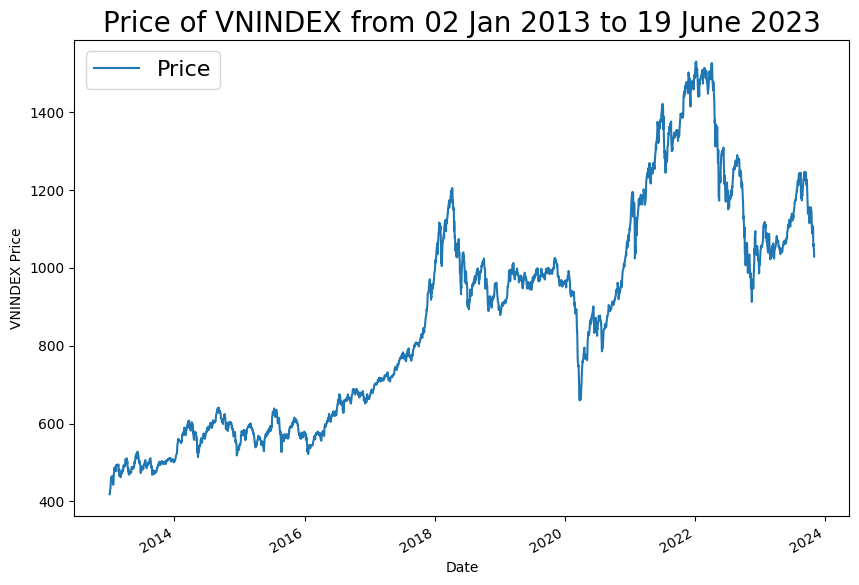

In [23]:
import matplotlib.pyplot as plt
stock_prices.plot(figsize=(10, 7))
plt.ylabel("VNINDEX Price")
plt.title("Price of VNINDEX from 02 Jan 2013 to 19 June 2023", fontsize=20)
plt.legend(fontsize=16);

In [24]:
#Prepare data
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 5 # how far to lookback

In [25]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
stock_prices.head()

,Price
Date,
2013-01-02,418.35
2013-01-03,419.27
2013-01-04,426.06
2013-01-07,434.19
2013-01-08,447.16


In [26]:
# Add windowed columns
stock_prices_nbeats = stock_prices.copy()
for i in range(WINDOW_SIZE):
  stock_prices_nbeats[f"Price-{i+1}"] = stock_prices_nbeats["Price"].shift(periods=i+1)
stock_prices_nbeats.dropna().head()


,Price,Price-1,Price-2,Price-3,Price-4,Price-5
Date,,,,,,
2013-01-09,448.77,447.16,434.19,426.06,419.27,418.35
2013-01-10,460.12,448.77,447.16,434.19,426.06,419.27
2013-01-11,462.69,460.12,448.77,447.16,434.19,426.06
2013-01-14,458.97,462.69,460.12,448.77,447.16,434.19
2013-01-15,461.42,458.97,462.69,460.12,448.77,447.16


In [27]:
# Make features and labels
X = stock_prices_nbeats.dropna().drop("Price", axis=1)
y = stock_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2157, 2157, 540, 540)

Text(2018-12-06 00:00:00, 1220.27, '2157 quan sát')

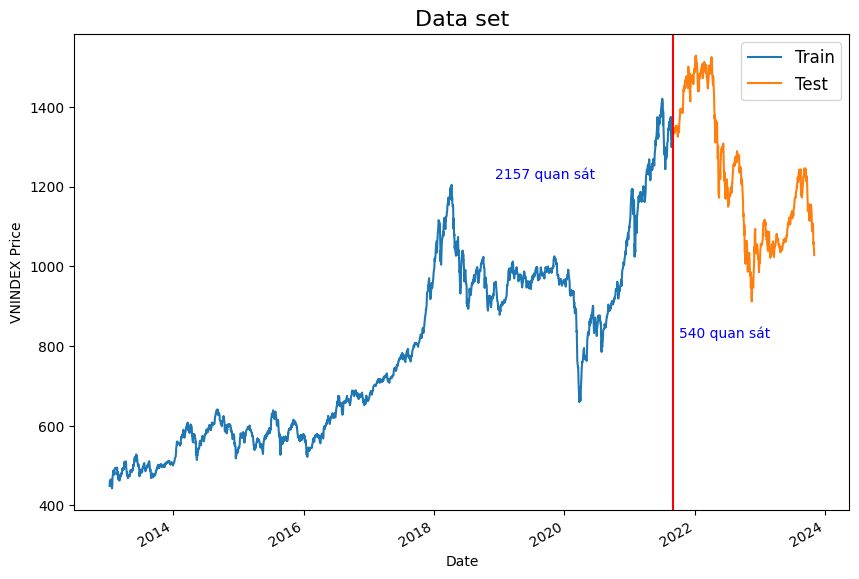

In [28]:
split_date=y_train.index[-1]
y_train.plot(figsize=(10, 7),label='Train')
y_test.plot(figsize=(10, 7),label='Test')
plt.axvline(x=pd.to_datetime(split_date), color='r', linestyle='-')
plt.ylabel("VNINDEX Price")
plt.title("Data set", fontsize=16)
plt.legend(fontsize=12)
plt.text(split_date + pd.DateOffset(days=30), y_train.max() - 600, f'{len(y_test)} quan sát', fontsize=10, color='blue')
plt.text(split_date -pd.DateOffset(days=1000), y_train.max() - 200, f'{len(y_train)} quan sát', fontsize=10, color='blue')

In [ ]:
import tensorflow as tf

In [72]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [73]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(5, 6)

In [74]:
from tensorflow.keras import layers
#dermo subtract, add stacks
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [75]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [76]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 217: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 532: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 632: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: total: 55min 8s
Wall time: 15min 21s


In [77]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 125ms/step - loss: 11.1392 - mae: 11.1392 - mse: 252.8149


[11.139212608337402, 11.139212608337402, 252.8148651123047]

In [78]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained o  n)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [79]:
# Make predictions with N-BEATS model
model_preds = make_preds(model, test_dataset)
model_preds

1/1 [==============================] - 1s 987ms/step


<tf.Tensor: shape=(540,), dtype=float32, numpy=
array([1335.8656 , 1347.4077 , 1343.5878 , 1335.0999 , 1343.1476 ,
       1346.7205 , 1343.0599 , 1339.908  , 1346.046  , 1347.0127 ,
       1353.0818 , 1351.3315 , 1341.5437 , 1350.114  , 1354.0797 ,
       1352.7717 , 1327.4949 , 1337.1987 , 1340.9666 , 1344.4298 ,
       1335.5885 , 1339.8645 , 1355.1967 , 1365.3763 , 1367.694  ,
       1373.9097 , 1396.0009 , 1398.5072 , 1393.1865 , 1392.0745 ,
       1393.3954 , 1396.4059 , 1396.2113 , 1394.6533 , 1385.9159 ,
       1389.5939 , 1386.472  , 1392.6608 , 1424.8226 , 1443.2909 ,
       1447.5314 , 1440.8556 , 1452.4542 , 1445.9926 , 1449.3119 ,
       1456.8888 , 1469.2902 , 1463.5278 , 1465.5023 , 1462.8729 ,
       1474.1039 , 1478.2479 , 1468.623  , 1475.6016 , 1471.1184 ,
       1455.6075 , 1446.4536 , 1463.8275 , 1491.9365 , 1505.5669 ,
       1495.9766 , 1486.306  , 1478.3331 , 1485.972  , 1484.0862 ,
       1448.2455 , 1411.733  , 1440.8341 , 1457.2806 , 1469.4497 ,
       1466.19

In [80]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [81]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [82]:
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 11.139213,
 'mse': 252.81487,
 'rmse': 15.900153,
 'mape': 0.92816865,
 'mase': 1.021466}

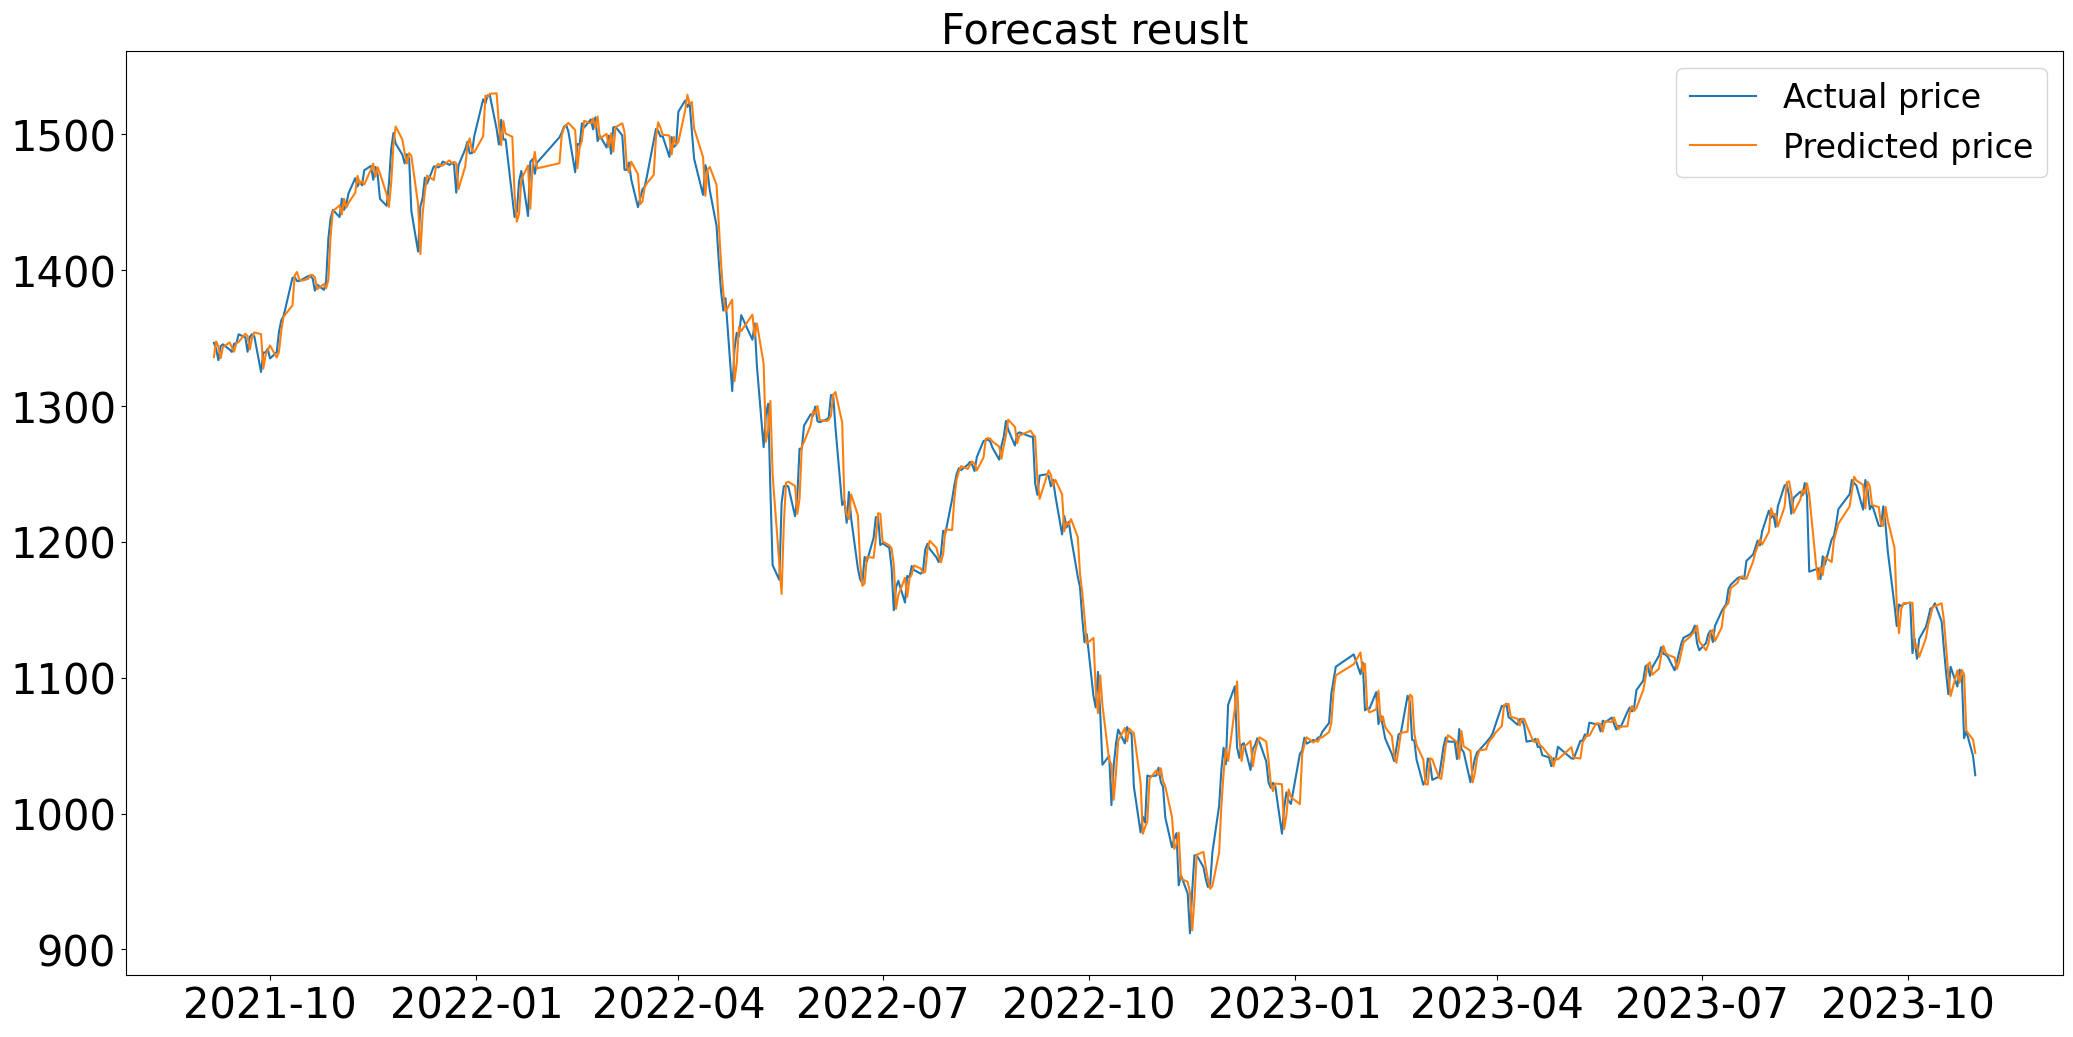

In [84]:
plt.figure(figsize=(25, 12))
plt.plot(stock_prices.index[2162:], prices[2162:], "-", label="Actual price")
plt.plot(stock_prices.index[2162:], model_preds, "-", label="Predicted price")
plt.title("Forecast reuslt", fontsize=30)
plt.legend(fontsize=24)
plt.tick_params( labelsize=30)

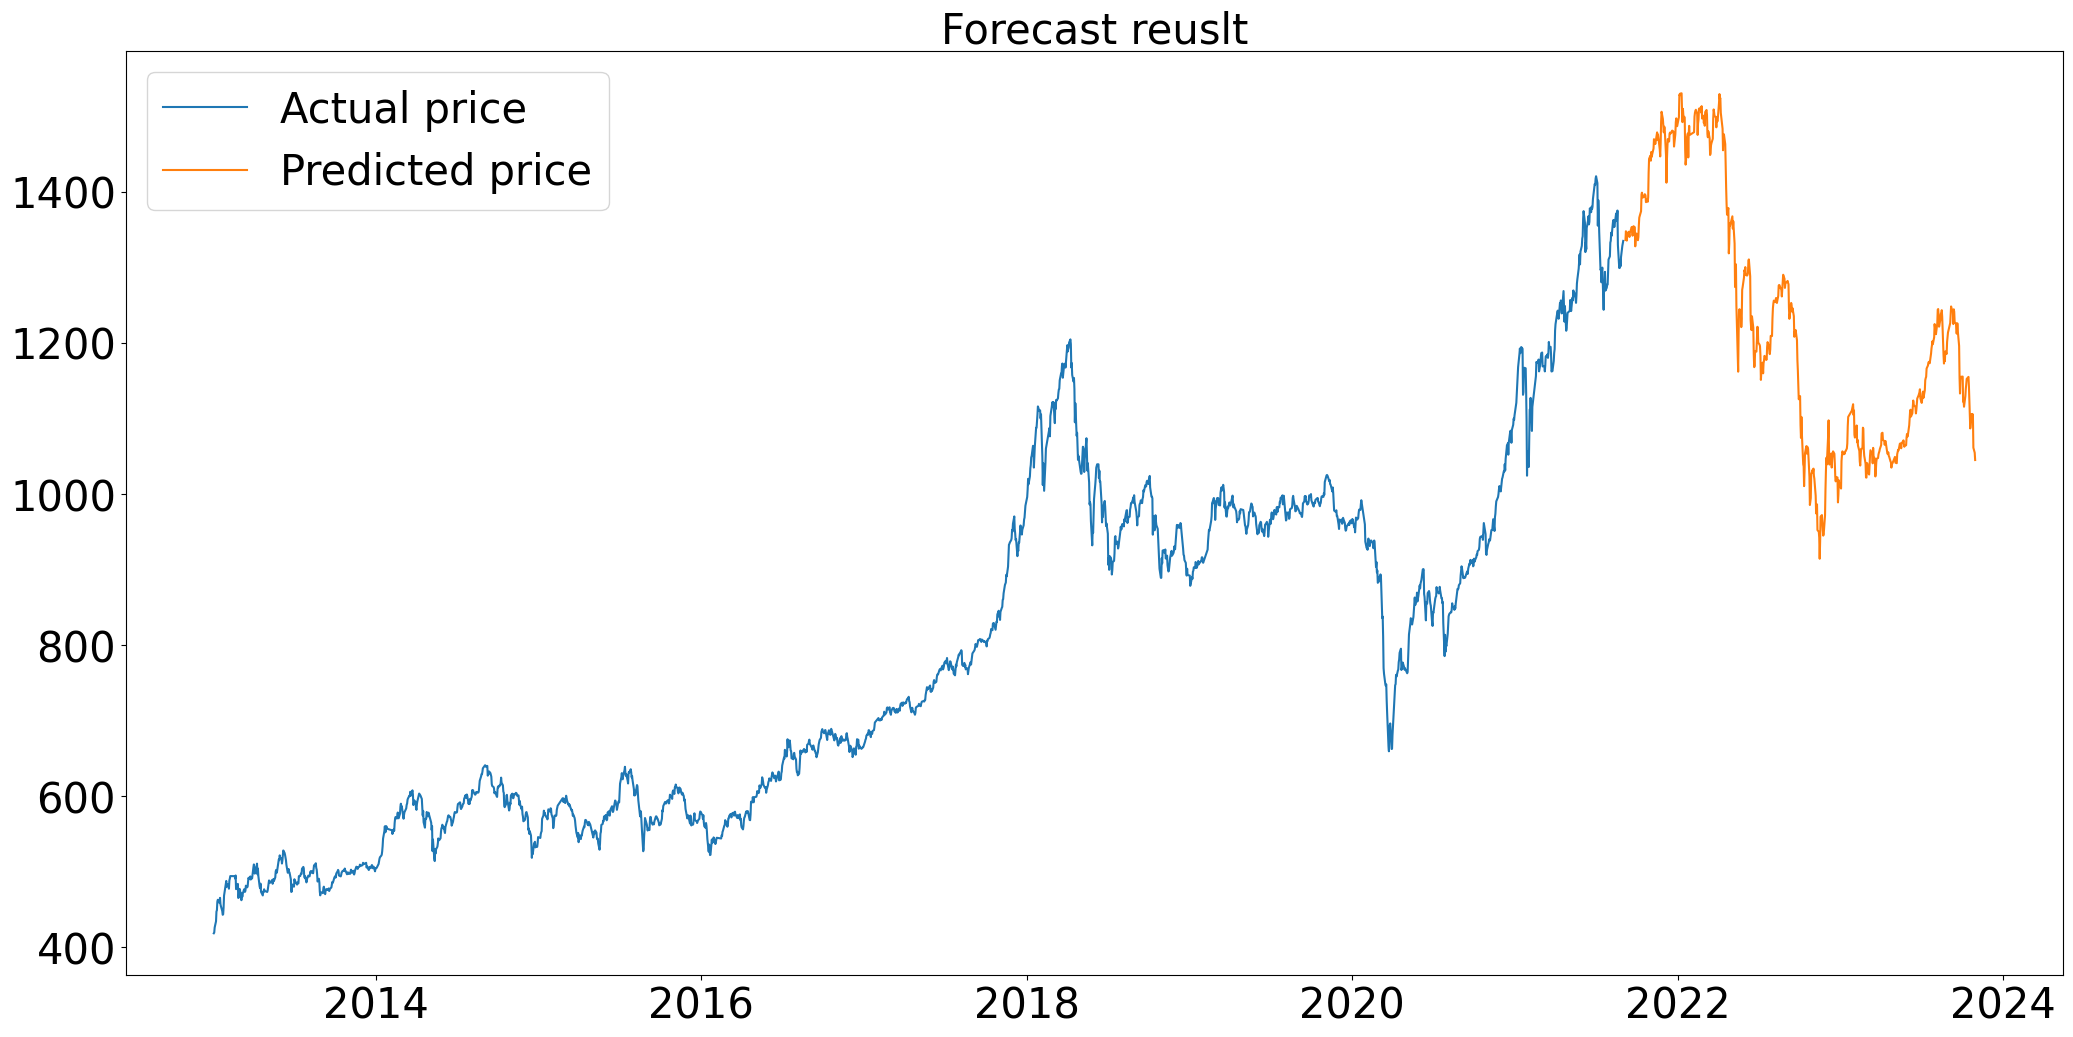

In [85]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(25, 12))
plt.plot(stock_prices.index[:2162], prices[:2162], "-", label="Actual price")
plt.plot(stock_prices.index[2162:], model_preds, "-", label="Predicted price")
plt.title("Forecast reuslt", fontsize=30)
plt.legend(fontsize=30)
plt.tick_params(labelsize=30);


In [86]:
model.save('model7')

INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets
